# Purpose: Produce estimate atmospheric lifetime and use it to combine reported emissions and emissions inferred from data sources described at the end of this notebook.

Clear all variables and reset the working directory and import necessary libraries

In [1]:
%reset -f
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import csv
import xlrd
from xlrd import open_workbook
from openpyxl import Workbook
os.chdir('C:\\Users\\cd7\\Desktop\\Heat17N2O')

Read three input files separately and assign the year values and methane concentration data

In [2]:
df1 = pd.read_excel('v432_N2O_1970_2012.xls','v4.3.2_EM_N2O')
df1.to_csv('v432_N2O_1970_2012.csv',header=False,index=False)
df1 = pd.read_csv('v432_N2O_1970_2012.csv')
# print (df1)

df2 = pd.read_excel('v432_N2O_1970_2012.xls','TOTALS BY COUNTRY')
df2.to_csv('TOTALS BY COUNTRY.csv',header=False,index=False)
df2 = pd.read_csv('TOTALS BY COUNTRY.csv')

df4 = pd.read_excel('heat17-n2o-1-2017dec16.xlsx')
df4.to_csv('heat17-n2o-1-2017dec14.csv',header=False,index=False)
df4 = pd.read_csv('heat17-n2o-1-2017dec14.csv')
df4.drop(df4.index[[-1]],inplace=True)
# print (df4)

In [3]:
out1 = 'heat'
out2 = 'n2oemit'
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'] # abbreviations for months to insert in output file name
date = datetime.date.today().strftime("%Y-%m-%d")
date_split = date.split('-') # split the date string we create by symbol "-"
yrs = str(int(date_split[0])-2000) # real years minus 2000 
seq = [out1, yrs, out2,months[int(date_split[1])-1],date_split[2]]
seperator = ','
filename = seperator.join(seq).replace(',', '')
print (filename)

heat18n2oemitjul14


0     1970
1     1971
2     1972
3     1973
4     1974
5     1975
6     1976
7     1977
8     1978
9     1979
10    1980
11    1981
12    1982
13    1983
14    1984
15    1985
16    1986
17    1987
18    1988
19    1989
20    1990
21    1991
22    1992
23    1993
24    1994
25    1995
26    1996
27    1997
28    1998
29    1999
30    2000
31    2001
32    2002
33    2003
34    2004
35    2005
36    2006
37    2007
38    2008
39    2009
40    2010
41    2011
42    2012
Name: 0, dtype: object
0     0.712040
1     0.726800
2     0.747871
3     0.777534
4     0.792040
5     0.806895
6     0.826444
7     0.846325
8     0.867738
9     0.889481
10    0.890164
11    0.890209
12    0.882741
13    0.900335
14    0.923755
15    0.920884
16    0.927896
17    0.939972
18    0.949666
19    0.960849
20    0.943324
21    0.937590
22    0.944500
23    0.940931
24    0.958255
25    0.988550
26    1.008630
27    1.008973
28    1.002127
29    1.003757
30    1.008356
31    1.014140
32    1.026559
33    1.0

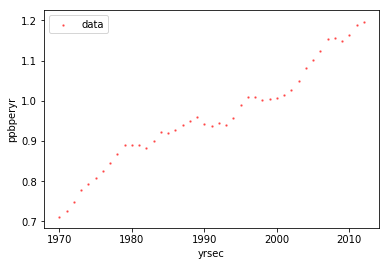

In [4]:
convert = 2.78*(28 + 16)/16 # (* rescale Gtonne to ppb from CH4 to N2O *)

yrsec = df1.iloc[0,6:49]
yrsec.index = np.arange(0, len(yrsec))
print (yrsec)
df2 = df2.iloc[1:]  # ecall = df2
df2 = df2.fillna(0) # replace all the NaN values with Zero's in a pandas dataframe
df2.index = np.arange(0, len(df2))

ecbycontryraw = [] 
for i in range(0,len(df2)):
    sub_list=[]
    for m in range(6,len(df2.columns)):
        x = df2.iloc[i,m].tolist()
        sub_list.append(float(x))
    ecbycontryraw.append(sub_list)
  
giggatonneperyr = df2.iloc[:, 6:len(df2.columns)].sum(axis=0)/1000
ppbperyr = giggatonneperyr/convert
ppbperyr.index = np.arange(0, len(ppbperyr))
# ppbperyr=ppbperyr.tolist()
# print (giggatonneperyr)
print (ppbperyr)

df3 = pd.concat([yrsec, ppbperyr], axis=1).reset_index()
df3 = df3.drop('index',axis=1)
df3.columns = ['yrsec','ppbperyr']

print (df3)
df3 = df3.astype(float) # Cast a pandas object to a specified dtype float.
df3.plot.scatter(x='yrsec',y='ppbperyr',s=2,color = 'r', alpha = 0.5,label ='data',marker='o')
                           

N2O Data and Finite Differences

In [5]:
yrs2 = df4['Julian']
yrs2 = yrs2.iloc[1:-1]
# print (type(yrs2))

n2o = df4.iloc[:,1:2]
n2o = n2o['ppb'].tolist()
n2o = list(map(float, n2o))

dn2odt = []

for i in range(0,len(n2o)-2):
        x = (n2o[i+2]-n2o[i])/2
        dn2odt.append(float(x))
# print (len(dn2odt))
# print (dn2odt)

n2o0 = 269.291 #(* long term limit of constant + logistic fit for 200-1749 from heat17<n2o>dec16.nb *)

b0 = dn2odt[int(yrsec.iloc[-1])-1]
# print (b0)



index1 = list(range(int(yrsec.iloc[0])-1, int(yrsec.iloc[-1])))
index2 = list(range(int(yrsec.iloc[0]), int(yrsec.iloc[-1])+1))

c0 = [ dn2odt[i] for i in index1]
# print(c0)

c1 = [ n2o[i] for i in index2]

# print(len(c1))
# print(c1)
# print(c1[0]-n2o0)
ppbperyr = df3['ppbperyr'].tolist()
ppbperyr = list(map(float, ppbperyr))

l1 = [ppbperyr[i]-c0[i] for i in range(0,len(c0))]
# print(len(l1))
# print(l1)

In [6]:
def err(d0,lifetofind):
    y = (d0 - n2o0)/lifetofind
    return y
param_bounds=(0,200)
popt, pcov = curve_fit(err, c1, l1, bounds=param_bounds)
print (popt)

[182.04369496]


In [7]:
tlastpre = 1749
# print (len(n2o))
# del n2o[-3]
n2o = n2o[1:-1]
# print (len(n2o))
x = np.array(n2o)
fit = err(x, *popt)
emitlate = fit + dn2odt
emitlate = emitlate[tlastpre-1:] 

yrs2 = yrs2.tolist()
yrs2 = list(map(int, yrs2))
yrslate = yrs2[tlastpre-1:]

itemindex1 = yrslate.index(int(yrsec[0]))
itemindex2 = yrslate.index(int(yrsec.iloc[-1]))

# print(itemindex1)
# print(itemindex2)
# print (emitlate[itemindex1:itemindex2+1])
rescale = np.mean(ppbperyr)/np.mean(emitlate[itemindex1:itemindex2+1])
print (rescale)
# print (emitlate[itemindex])
# print(ppbperyr[0])

1.0006525653702771
